In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import interpolate
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value

from read import read_pbh, output_specs

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict, save_h5_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [2]:
results_dir = '/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results'
run_name = 'm13.200_sec'

run_dir = f"{results_dir}/{run_name}"

## 1. Evolution

In [3]:
evol_data = read_pbh(run_dir, 'evolution')
#t, M, dt = evol_data['t'], evol_data['M'], evol_data['dt']

In [4]:
print(f"{evol_data['M0']:.3e}", evol_data['units']['M0'])
print(evol_data['rho_comov'], evol_data['units']['rho_comov'])

1.585e+13 g
1.0 1 / cm3


In [5]:
print(f'{cosmo.age(0).to(u.s).value:.3e} s')

4.351e+17 s


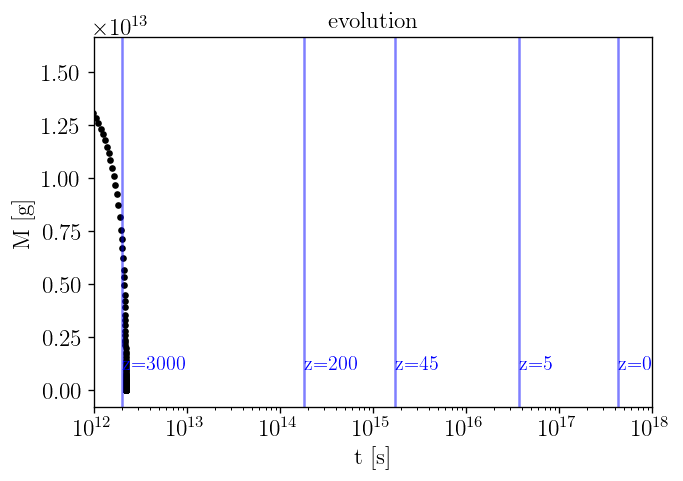

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

#ax = axs[0]
ax.plot(evol_data['t'], evol_data['M'], 'k.')
ax.set(xlabel='t [s]', ylabel='M [g]', title='evolution')

# # energy loss
# ind_first = 0
# ind_last = -1
# dMdt_s = - np.gradient(evol_data['M'], evol_data['t']) * ((u.g*c.c**2 / u.eV).decompose()).value # [eV/s]

# ax = axs[1]
# ax.plot(evol_data['t'], dMdt_s, 'k.')
# ax.set(ylim=(0., 5e22))
# ax.set(xlabel='t [s]', ylabel='dM/dt [eV/s]', title='energy loss')

for z in [0, 5, 45, 200, 3000]:
    ax.set(xlim=(1e12, 1e18), xscale='log')
    t = cosmo.age(z).to(u.s).value
    ax.axvline(t, color='b', alpha=0.5)
    ax.text(t, ax.get_ylim()[1] * 0.1, f'z={z}', ha='left', va='top', color='b')

## 2. Primary spectrum

In [6]:
particles = output_specs(run_dir)
print(particles['primary'])

['strange', 'down', 'charm', 'wpm', 'higgs', 'bottom', 'muon', 'neutrinos', 'top', 'z0', 'tau', 'electron', 'up', 'photon', 'gluon', 'graviton']


### 2.1 Primary

In [7]:
phot_pri_data = read_pbh(run_dir, 'primary', 'photon')
elec_pri_data = read_pbh(run_dir, 'primary', 'electron')

In [8]:
#abscs = load_h5_dict(f"{os.environ['DM21CM_DATA_DIR']}/tf/zf002/data/abscissas.h5")
abscs = load_h5_dict(f"/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data/abscissas.h5")

In [9]:
def t_inds(t_s, z_start, z_end):
    t_start = cosmo.age(z_start).to(u.s).value
    ind_t_start = np.searchsorted(t_s, t_start) - 1
    t_end = cosmo.age(z_end).to(u.s).value
    ind_t_end = np.searchsorted(t_s, t_end) + 1
    if ind_t_end >= len(t_s):
        ind_t_end = len(t_s) - 1
    return ind_t_start, ind_t_end

print(t_inds(evol_data['t'], 4000, 5))

def interp_dNdEdt(t_s, src_E, src_dNdEdt, tar_Ek, mass=0):
    """
    Args:
        t (1D array): time [s]
        src_E (1D array): source total energy (kinetic + mass) [eV]
        src_dNdEdt (2D array): source dNdEdt data. first dimension is time, second is energy [1/eV s]
        tar_Ek (1D array): target kinetic energy [eV]
        mass (float): mass of the particle [eV]
    """
    ind_t_start, ind_t_end = t_inds(t_s, 4000, 5)
    t_sub = t_s[ind_t_start:ind_t_end]
    dNdEdt_sub = np.zeros((len(t_sub), len(tar_Ek)))
    for ind in range(ind_t_start, ind_t_end):
        interp = interpolate.interp1d(src_E, src_dNdEdt[ind], fill_value=0., bounds_error=False)
        dNdEdt_sub[ind-ind_t_start] = interp(tar_Ek + mass)
    return t_sub, dNdEdt_sub

(135, 688)


In [10]:
t_phot, dNdEdt_phot = interp_dNdEdt(evol_data['t'], phot_pri_data['E'], phot_pri_data['dN_dEdt'], abscs['photE'], mass=0)
t_elec, dNdEdt_elec = interp_dNdEdt(evol_data['t'], elec_pri_data['E'], elec_pri_data['dN_dEdt'], abscs['elecEk'], mass=phys.m_e)

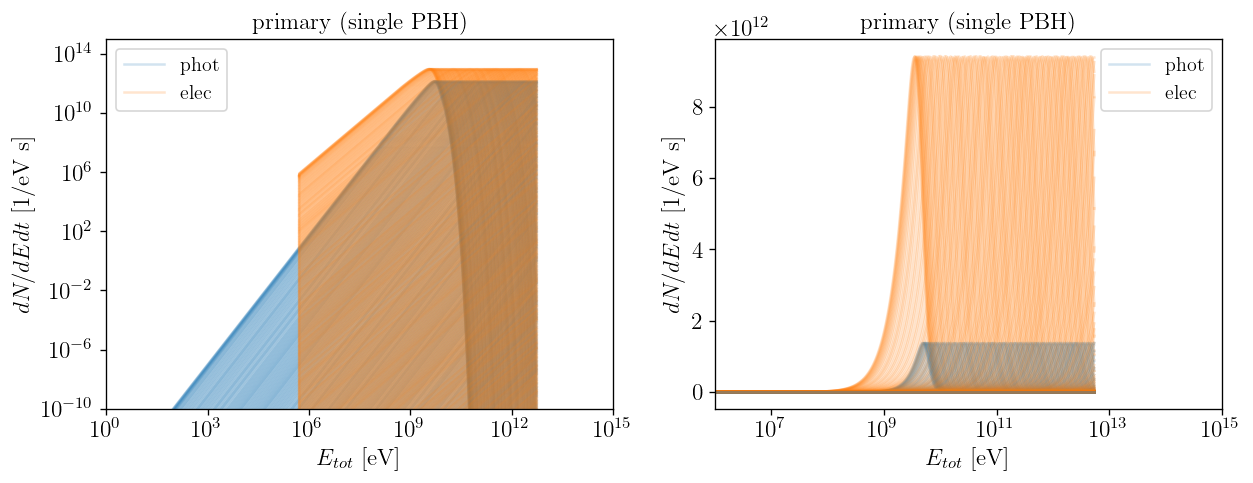

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
labeled = False
for spec_phot, spec_elec in zip(dNdEdt_phot, dNdEdt_elec):
    axs[0].plot(abscs['photE'], spec_phot, 'C0', alpha=0.2, label=('phot' if not labeled else None))
    axs[1].plot(abscs['photE'], spec_phot, 'C0', alpha=0.2, label=('phot' if not labeled else None))
    axs[0].plot(abscs['elecEk']+phys.m_e, spec_elec, 'C1', alpha=0.2, label=('elec' if not labeled else None))
    axs[1].plot(abscs['elecEk']+phys.m_e, spec_elec, 'C1', alpha=0.2, label=('elec' if not labeled else None))
    labeled = True
axs[0].set(xscale='log', yscale='log', xlim=(1e0, 1e15), ylim=(1e-10, 1e15))
axs[1].set(xscale='log', xlim=(1e6, 1e15))
for ax in axs:
    ax.set(xlabel=r'$E_{tot}$ [eV]', ylabel=r'$dN/dEdt$ [1/eV s]', title='primary (single PBH)')
    ax.legend()

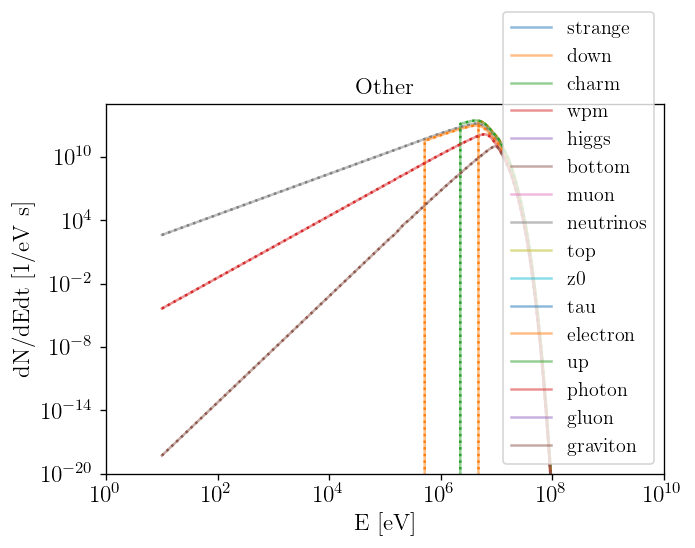

In [78]:
# other particles
ind_ref, ind_ref_2 = t_inds(evol_data['t'], 45, 5)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, p in enumerate(particles['primary']):
    data = read_pbh(run_dir, 'primary', p)
    ax.plot(data['E'], data['dN_dEdt'][ind_ref], '-', color=f'C{i}', alpha=0.5, label=p)
    ax.plot(data['E'], data['dN_dEdt'][ind_ref_2], ':', color=f'C{i}', alpha=1.0)
ax.set(xlim=(1e0, 1e10), ylim=(1e-20, 1e15), xscale='log', yscale='log')
ax.set(xlabel='E [eV]', ylabel='dN/dEdt [1/eV s]', title='Other')
ax.legend();

### 2.2 Secondary

In [14]:
logm = 13.2
run_name = f'm{logm:.3f}_sec'
run_dir = f"{results_dir}/{run_name}"

evol_data = read_pbh(run_dir, 'evolution')
particles = output_specs(run_dir)
phot_pri_data = read_pbh(run_dir, 'primary', 'photon')
elec_pri_data = read_pbh(run_dir, 'primary', 'electron')
phot_sec_data = read_pbh(run_dir, 'secondary', 'photon')
elec_sec_data = read_pbh(run_dir, 'secondary', 'electron')

t_phot, dNdEdt_phot = interp_dNdEdt(evol_data['t'], phot_pri_data['E'], phot_pri_data['dN_dEdt'], abscs['photE'], mass=0)
t_elec, dNdEdt_elec = interp_dNdEdt(evol_data['t'], elec_pri_data['E'], elec_pri_data['dN_dEdt'], abscs['elecEk'], mass=phys.m_e)
t_phot, dNdEdt_phot_sec = interp_dNdEdt(evol_data['t'], phot_sec_data['E'], phot_sec_data['dN_dEdt'], abscs['photE'], mass=0)
t_elec, dNdEdt_elec_sec = interp_dNdEdt(evol_data['t'], elec_sec_data['E'], elec_sec_data['dN_dEdt'], abscs['elecEk'], mass=phys.m_e)

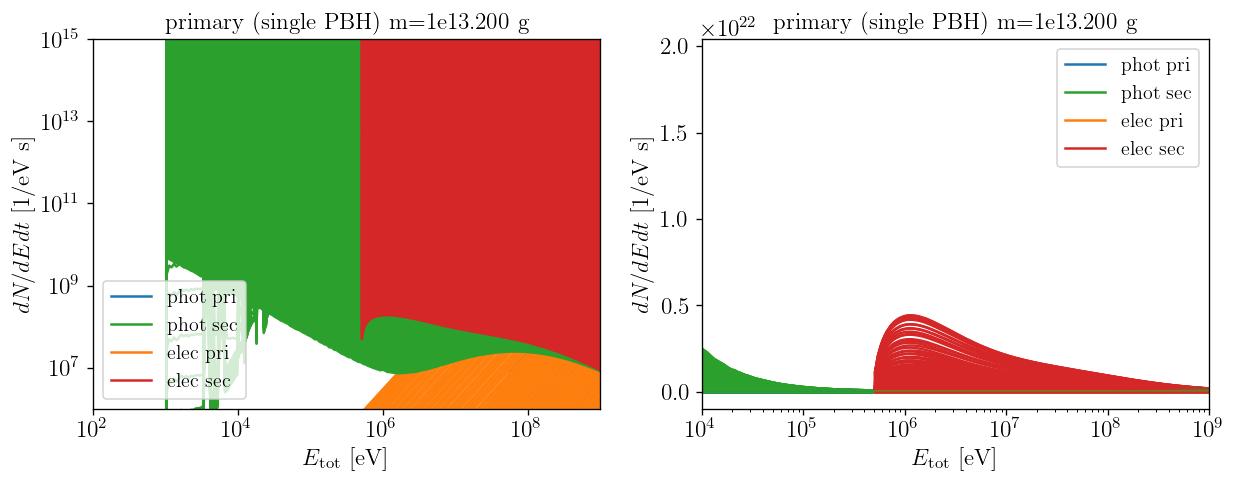

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
labeled = False
for spec_phot, spec_elec, spec_phot_sec, spec_elec_sec in zip(dNdEdt_phot, dNdEdt_elec, dNdEdt_phot_sec, dNdEdt_elec_sec):
    alpha = 1
    label = 'phot pri' if not labeled else None
    axs[0].plot(abscs['photE'], spec_phot, 'C0', alpha=alpha, label=label)
    axs[1].plot(abscs['photE'], spec_phot, 'C0', alpha=alpha, label=label)
    label = 'phot sec' if not labeled else None
    axs[0].plot(abscs['photE'], spec_phot_sec, 'C2', alpha=alpha, label=label)
    axs[1].plot(abscs['photE'], spec_phot_sec, 'C2', alpha=alpha, label=label)

    label = 'elec pri' if not labeled else None
    axs[0].plot(abscs['elecEk']+phys.m_e, spec_elec, 'C1', alpha=alpha, label=label)
    axs[1].plot(abscs['elecEk']+phys.m_e, spec_elec, 'C1', alpha=alpha, label=label)
    label = 'elec sec' if not labeled else None
    axs[0].plot(abscs['elecEk']+phys.m_e, spec_elec_sec, 'C3', alpha=alpha, label=label)
    axs[1].plot(abscs['elecEk']+phys.m_e, spec_elec_sec, 'C3', alpha=alpha, label=label)
    labeled = True
axs[0].set(xscale='log', yscale='log', xlim=(1e2, 1e9), ylim=(1e6, 1e15))
axs[1].set(xscale='log', xlim=(1e4, 1e9))
for ax in axs:
    ax.set(xlabel=r'$E_\mathrm{tot}$ [eV]', ylabel=r'$dN/dEdt$ [1/eV s]', title=f'primary (single PBH) m=1e{logm:.3f} g')
    ax.legend()

In [85]:
# save
data = {
    't' : t_phot,
    'phot dNdEdt': dNdEdt_phot_sec,
    'elec dNdEdt': dNdEdt_elec_sec,
    'units' : 't: [s]; dNdEdt: [1/eV s BH]'
}
save_h5_dict(f"{os.environ['DM21CM_DIR']}/data/pbh/pbh_logm{logm:.3f}.h5", data)

## 3. Appropriate injection level

In [48]:
# 1e8: phot: ~1e27  , elec: ~1e29  , since elec N > phot, go with elec
# 1e7: phot: ~1e27.3, elec: ~1e28.6, since elec N > phot, go with elec
# 1e6: phot: ~1e27.7, elec: ~1e27.1, since elec N ~ elec, go with phot
# 1e5: phot: ~1e28  , elec: -------, since phot N > elec, go with phot

In [65]:
sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.injections.dm import DMDecayInjection
from dm21cm.injections.pbh import PBHInjection

In [86]:
dmdecay = DMDecayInjection(primary='phot_delta', m_DM=1e7, lifetime=10**28.6)
pbh = PBHInjection(m_PBH=1e16, f_PBH=3e-7)
pbh.set_binning(abscs)
for z in [3000, 45, 5]:
    print(f'z={z:5d}  decay -> {dmdecay.inj_power(z):.3e}  pbh -> {pbh.inj_power(z):.3e} eV / pcm^3 s')

z= 3000  decay -> 8.537e-16  pbh -> 3.496e-16 eV / pcm^3 s
z=   45  decay -> 3.074e-21  pbh -> 1.259e-21 eV / pcm^3 s
z=    5  decay -> 6.823e-24  pbh -> 2.794e-24 eV / pcm^3 s


# A. DM21cm parameters

In [21]:
sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.utils import load_h5_dict

In [22]:
abscs = load_h5_dict(os.environ['DM21CM_DATA_DIR'] + '/tf/zf002/data/abscissas.h5')

In [28]:
print(f"{np.min(abscs['photE']):.12e}, {np.max(abscs['photE']):.12e}")

1.039311037377e-04, 5.355424908403e+12


In [29]:
print(f"{np.min(abscs['elecEk']):.12e}, {np.max(abscs['elecEk']):.12e}")

1.029782576516e+00, 5.404978044972e+12
